In [2]:
%pip install numpy scikit-learn matplotlib scipy pandas

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-v0_8-darkgrid')

# Ładowanie danych
file_path = 'Myocardial infarction complications Database.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
    print("Upewnij się, że plik znajduje się w tym samym katalogu co skrypt lub podaj pełną ścieżkę.")
    exit()

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

imputer_numerical = SimpleImputer(strategy='median')
df_imputed = df.copy()
df_imputed[numerical_cols] = imputer_numerical.fit_transform(df_imputed[numerical_cols])

for col in categorical_cols:
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df_imputed[col] = imputer_categorical.fit_transform(df_imputed[[col]]).ravel()
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])

X = df_imputed.values

# Standaryzacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

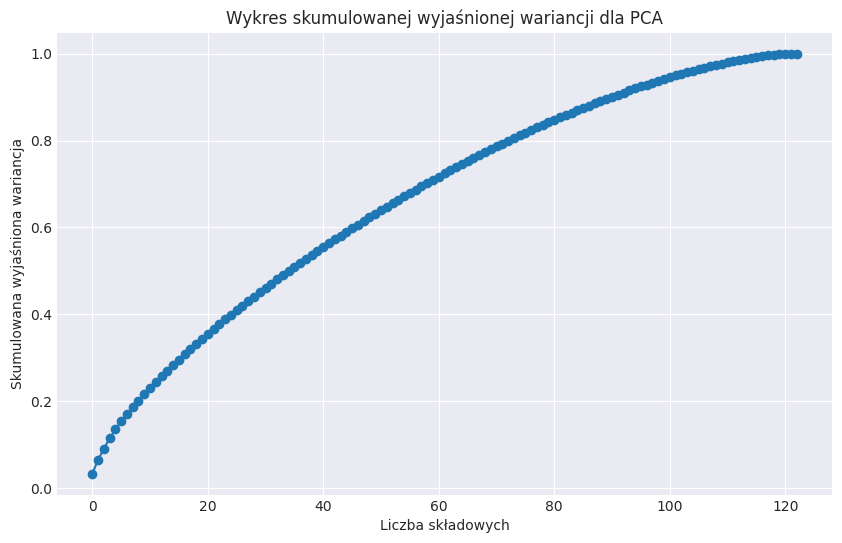

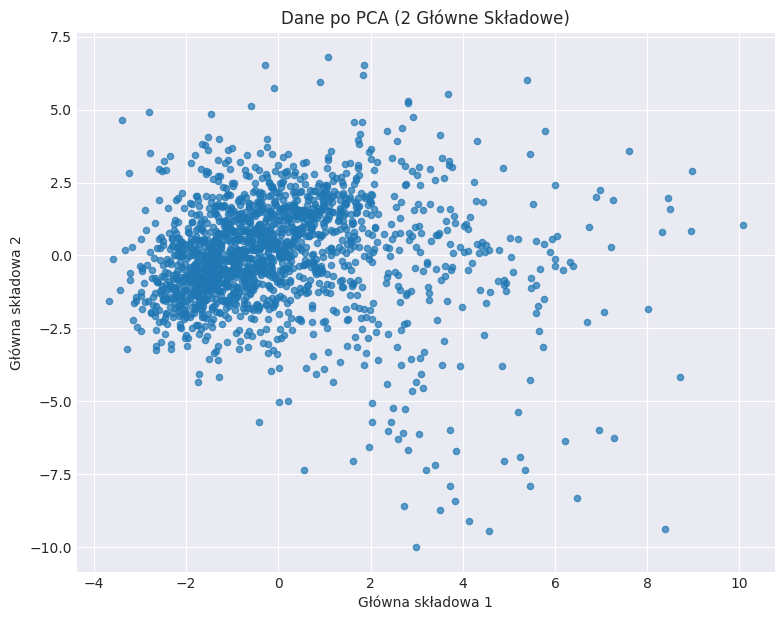

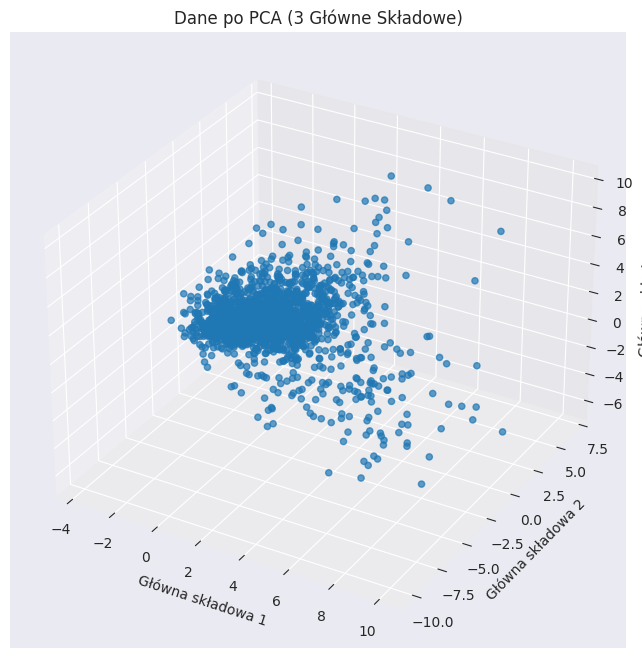

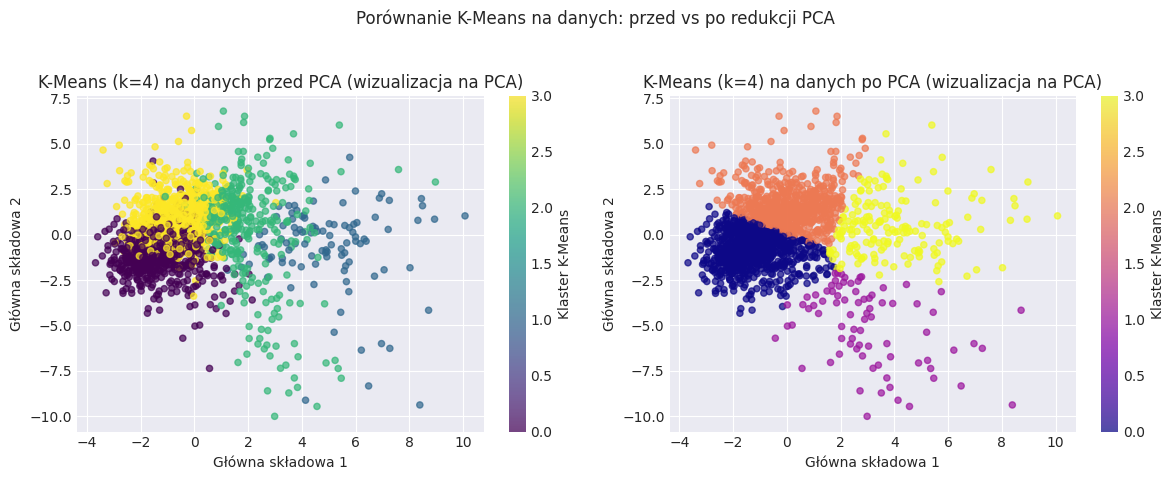

In [14]:
# Metoda PCA
# 7.1.1 Wykonaj analizę PCA na własnym zbiorze danych (np. dane z UCI Machine Learning Repository).
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Liczba składowych')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres skumulowanej wyjaśnionej wariancji dla PCA')
plt.grid(True)
plt.show()

# 7.1.2 Wykonaj wizualizację skupień dla 2 lub 3 głównych składowych.
plt.figure(figsize=(9, 7))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=20, alpha=0.7)
plt.title('Dane po PCA (2 Główne Składowe)')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], s=20, alpha=0.7)
ax.set_title('Dane po PCA (3 Główne Składowe)')
ax.set_xlabel('Główna składowa 1')
ax.set_ylabel('Główna składowa 2')
ax.set_zlabel('Główna składowa 3')
plt.show()

# 7.1.3 Porównaj wyniki klasteryzacji przed i po redukcji wymiarowości.
k_test = 4 # Użyjemy k=4 dla porównania (przed analizą elbow)

kmeans_before_pca = KMeans(n_clusters=k_test, random_state=42, n_init=10)
clusters_before_pca = kmeans_before_pca.fit_predict(X_scaled)
inertia_before_pca = kmeans_before_pca.inertia_

kmeans_after_pca = KMeans(n_clusters=k_test, random_state=42, n_init=10)
clusters_after_pca = kmeans_after_pca.fit_predict(X_pca_2d)
inertia_after_pca = kmeans_after_pca.inertia_

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_before_pca, cmap='viridis', s=20, alpha=0.7)
plt.title(f'K-Means (k={k_test}) na danych przed PCA (wizualizacja na PCA)')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(label='Klaster K-Means')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_after_pca, cmap='plasma', s=20, alpha=0.7)
plt.title(f'K-Means (k={k_test}) na danych po PCA (wizualizacja na PCA)')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(label='Klaster K-Means')
plt.grid(True)

plt.suptitle('Porównanie K-Means na danych: przed vs po redukcji PCA')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

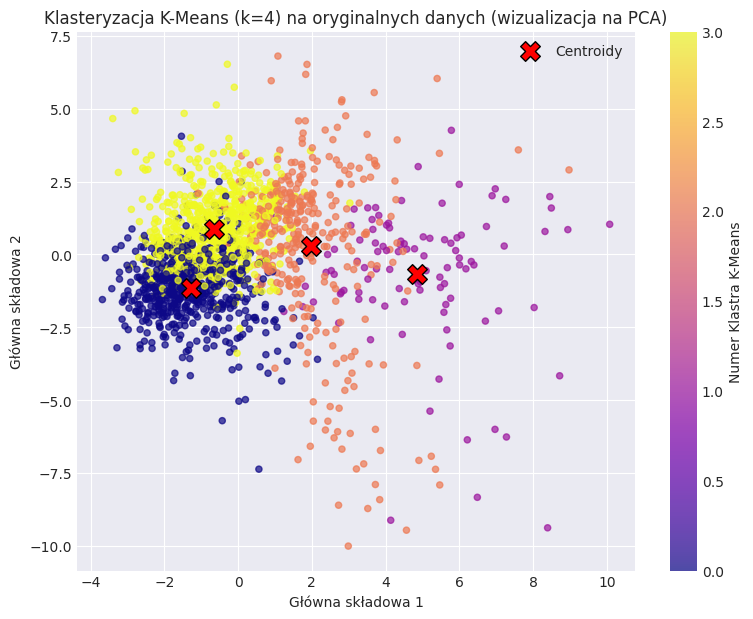

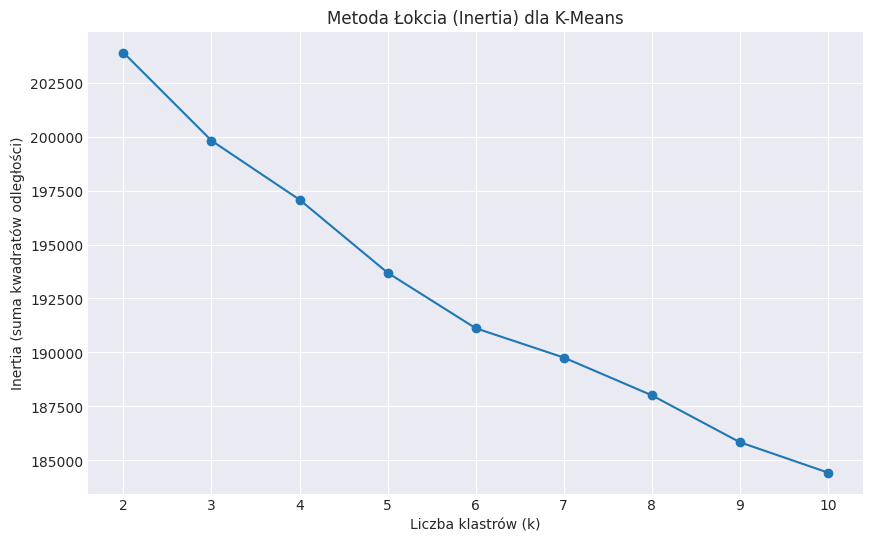

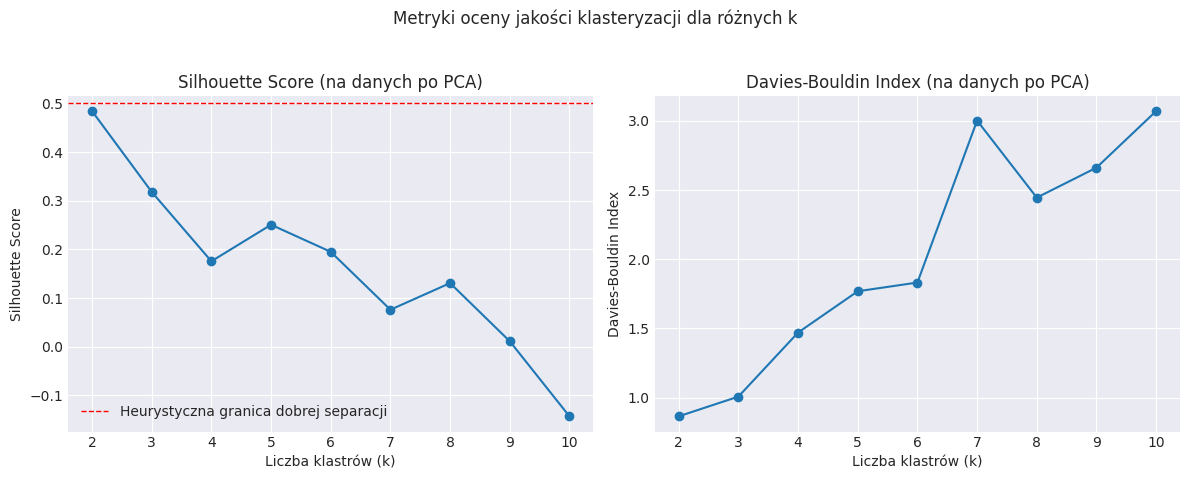

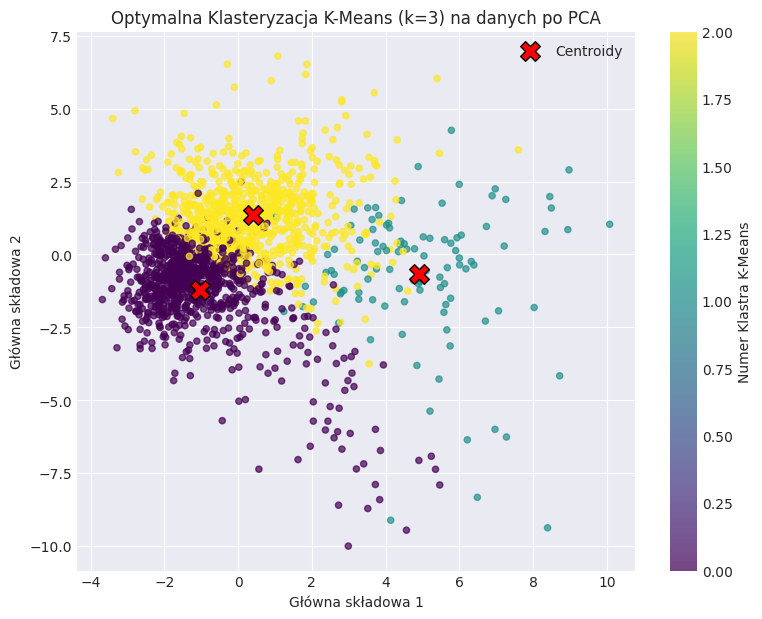

In [15]:
# Metody niehierarchiczne: Klasteryzacja k-means
# 7.2.1 Wykonaj klasteryzację k-means dla wybranego zbioru danych.
k_initial_demo = 4
kmeans_model = KMeans(n_clusters=k_initial_demo, random_state=42, n_init=10)
kmeans_clusters_initial = kmeans_model.fit_predict(X_scaled)
kmeans_centroids_initial = kmeans_model.cluster_centers_

kmeans_centroids_pca_initial = pca_2d.transform(kmeans_centroids_initial)

plt.figure(figsize=(9, 7))
scatter_kmeans = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_clusters_initial, cmap='plasma', s=20, alpha=0.7)
plt.scatter(kmeans_centroids_pca_initial[:, 0], kmeans_centroids_pca_initial[:, 1], marker='X', s=200, color='red', label='Centroidy', edgecolors='k')
plt.title(f'Klasteryzacja K-Means (k={k_initial_demo}) na oryginalnych danych (wizualizacja na PCA)')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(scatter_kmeans, label='Numer Klastra K-Means')
plt.legend()
plt.grid(True)
plt.show()

# 7.2.2 Przeprowadź analizę dla różnych wartości k. Wybierz optymalne k, korzystając z metody "łokcia" (ang. elbow method).
distortions = []
silhouette_scores = []
dbi_scores = []

K_range = range(2, 11)

for k in K_range:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans_k.fit_predict(X_scaled)
    distortions.append(kmeans_k.inertia_)
    
    silhouette_scores.append(silhouette_score(X_pca_2d, clusters))
    dbi_scores.append(davies_bouldin_score(X_pca_2d, clusters))

plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, marker='o', linestyle='-')
plt.title('Metoda Łokcia (Inertia) dla K-Means')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia (suma kwadratów odległości)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score (na danych po PCA)')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label='Heurystyczna granica dobrej separacji')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K_range, dbi_scores, marker='o', linestyle='-')
plt.title('Davies-Bouldin Index (na danych po PCA)')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(K_range)
plt.grid(True)

plt.suptitle('Metryki oceny jakości klasteryzacji dla różnych k')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

optimal_k = 3 # Przykładowy wybór na podstawie obserwacji wykresów

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(X_scaled)
kmeans_centroids_optimal = kmeans_optimal.cluster_centers_
kmeans_centroids_pca_optimal = pca_2d.transform(kmeans_centroids_optimal)

plt.figure(figsize=(9, 7))
scatter_optimal = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_optimal, cmap='viridis', s=20, alpha=0.7)
plt.scatter(kmeans_centroids_pca_optimal[:, 0], kmeans_centroids_pca_optimal[:, 1], marker='X', s=200, color='red', label='Centroidy', edgecolors='k')
plt.title(f'Optymalna Klasteryzacja K-Means (k={optimal_k}) na danych po PCA')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(scatter_optimal, label='Numer Klastra K-Means')
plt.legend()
plt.grid(True)
plt.show()

# 7.2.3 Porównaj wyniki z wcześniejszą analizą PCA (jeśli dane zostały wcześniej zredukowane wymiarowościowo).
# (Zostało to już wizualnie zrealizowane w 7.1.3 oraz powyżej dla optymalnego k)
# Wartości metryk dla K-Means po PCA:
silhouette_after_pca = silhouette_score(X_pca_2d, clusters_optimal)
dbi_after_pca = davies_bouldin_score(X_pca_2d, clusters_optimal)

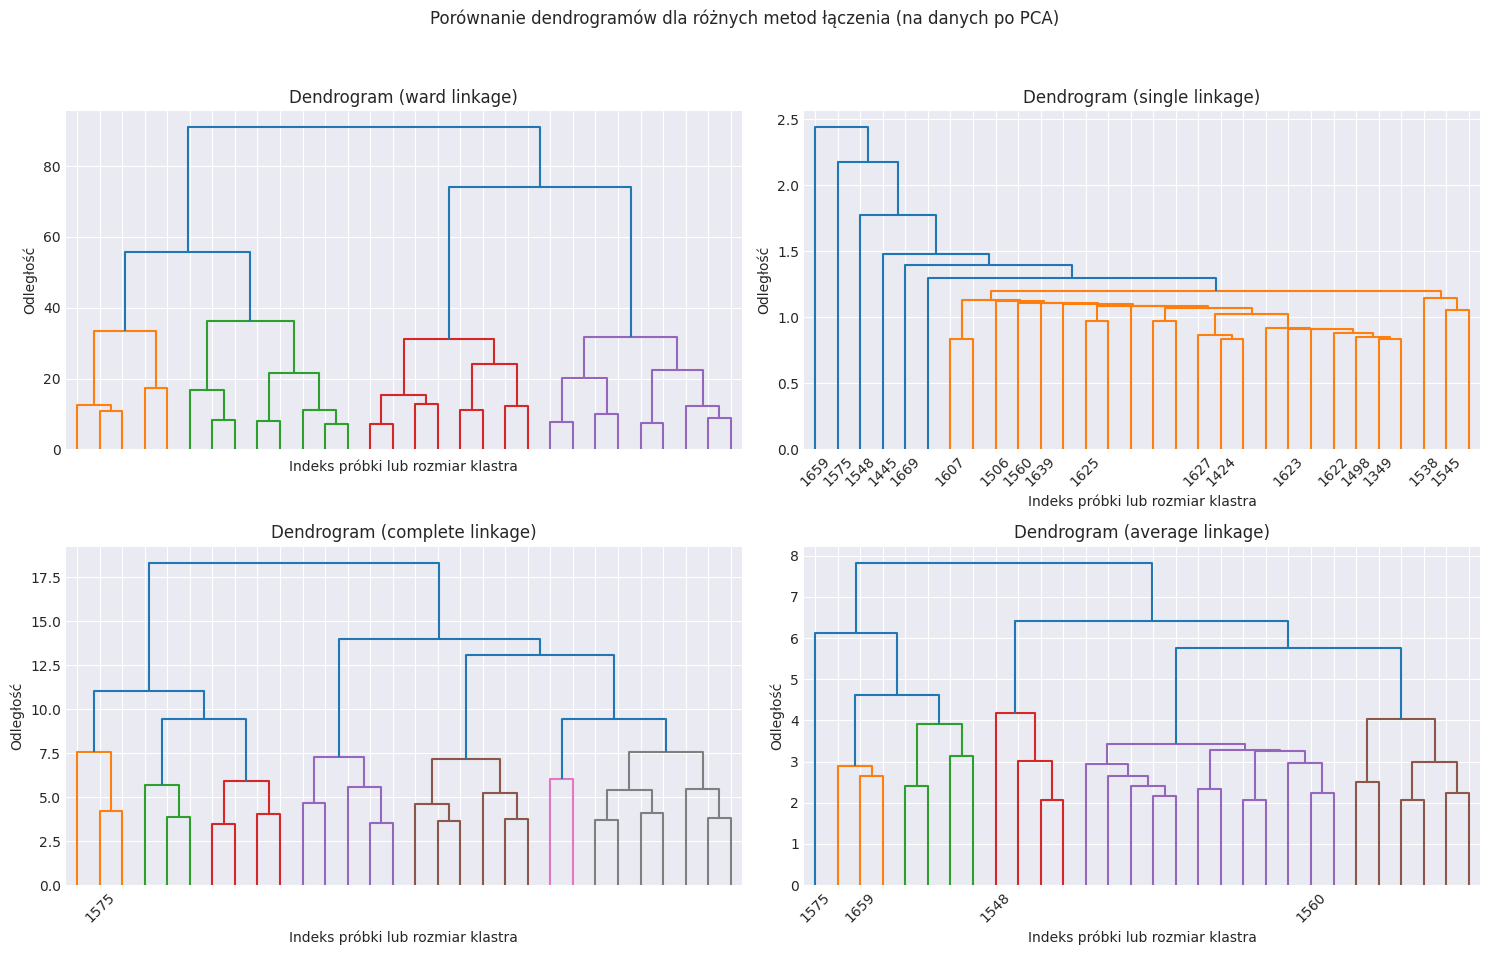

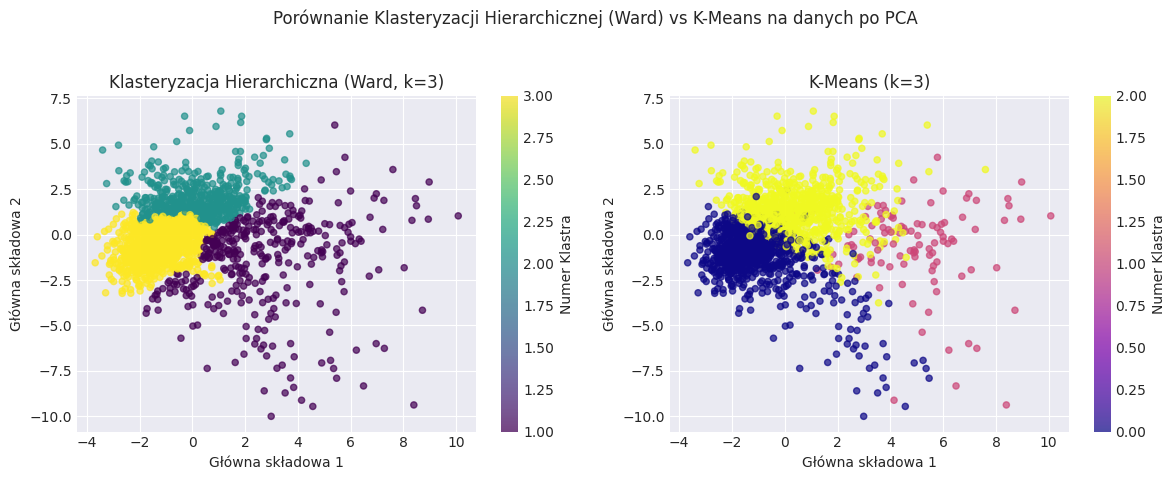

In [16]:


distance_matrix_hierarchical = pdist(X_pca_2d, metric='euclidean')

# 7.3.1 Wykonaj klasteryzację hierarchiczną na dowolnym zbiorze danych. Przeanalizuj wpływ różnych metod łączenia (np. Ward, single linkage, complete linkage) na strukturę dendrogramu.
linkage_methods = ['ward', 'single', 'complete', 'average']

plt.figure(figsize=(15, 10))
for i, method in enumerate(linkage_methods):
    linked_data = linkage(distance_matrix_hierarchical, method=method)
    
    plt.subplot(2, 2, i + 1)
    dendrogram(linked_data,
               truncate_mode='lastp',
               p=30,
               show_leaf_counts=False,
               color_threshold=0.7*linked_data[-optimal_k, 2])
    plt.title(f'Dendrogram ({method} linkage)')
    plt.xlabel('Indeks próbki lub rozmiar klastra')
    plt.ylabel('Odległość')
    plt.grid(True)

plt.suptitle('Porównanie dendrogramów dla różnych metod łączenia (na danych po PCA)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 7.3.2 Wyodrębnij klastry na różnych poziomach dendrogramu. Porównaj otrzymane wyniki z klasteryzacją k-means.
linked_ward = linkage(distance_matrix_hierarchical, method='ward')
hierarchical_clusters = fcluster(linked_ward, optimal_k, criterion='maxclust')

silhouette_hierarchical = silhouette_score(X_pca_2d, hierarchical_clusters)
dbi_hierarchical = davies_bouldin_score(X_pca_2d, hierarchical_clusters)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter_hierarchical_viz = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=hierarchical_clusters, cmap='viridis', s=20, alpha=0.7)
plt.title(f'Klasteryzacja Hierarchiczna (Ward, k={optimal_k})')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(scatter_hierarchical_viz, label='Numer Klastra')
plt.grid(True)

plt.subplot(1, 2, 2)
scatter_kmeans_comp_viz = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_optimal, cmap='plasma', s=20, alpha=0.7)
plt.title(f'K-Means (k={optimal_k})')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(scatter_kmeans_comp_viz, label='Numer Klastra')
plt.grid(True)

plt.suptitle('Porównanie Klasteryzacji Hierarchicznej (Ward) vs K-Means na danych po PCA')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()